# Tutorial: Interactive Maps with Python, Part 3
## Animated maps

In this final chapter of our 3-part series, we will set our data in motion. While folium has the capability of showing videos in a browser, we will only export our animations to separate video files (that you can then upload to youtube, etc.)

Let's start with some prerequisites. You'll need to install the selenium package for python:
```
pip install selenium
```
and you'll need to install phantom.js and ffmpeg on your system path.
you can find instructions here:

http://phantomjs.org/quick-start.html

and here:

https://ffmpeg.org/

In [1]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import pandas as pd
import folium
from folium import plugins
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap, rgb_to_hsv, hsv_to_rgb
import scipy.ndimage.filters
import time
import datetime
import os.path
import io

from multiprocessing import Pool

import os
os.environ["PATH"] += os.pathsep + "."

%matplotlib inline

We wrote a lot of code in the previous tutorials. I moved some of those functions to a separate file called consolidated_functions. We import it here as 'cf'.

In [2]:
import consolidated_functions as cf

And we load our data as usual.

In [3]:
bike_data = pd.read_csv("201610-citibike-tripdata.csv")
bike_data["Start Time"] = pd.to_datetime(bike_data["Start Time"])
bike_data["Stop Time"] = pd.to_datetime(bike_data["Stop Time"])
bike_data["hour"] = bike_data["Start Time"].map(lambda x: x.hour)


## Net arrivals
The first challenge we run into is that we want to generate movies that vary smoothly in time. This means that we have to generate a sufficiently large number of frames over the (real-world) Time span that we want to visualize. Option one is to aggregate the bike data into smaller time intervals, say, every minute. The problem with that approach is that there is a loss of variation in the number of arrivals at each station from minute to minute.

Therefore, we will take a different approach: we will still aggregate by hour but we will interpolate values for intermediate times.

In [12]:
def interpolate(df1, df2, x):
    """return a weighted average of two dataframes"""
    df = df1 * (1 - x) + df2 * x
    return df.replace(np.nan, 0)

def get_trip_counts_by_minute(float_hour, data):
    """get an interpolated dataframe for any time, based
    on hourly data"""
    
    columns = ["Start Station Latitude",
               "Start Station Longitude",
               "Departure Count",
               "Arrival Count"]
    df1 = cf.get_trip_counts_by_hour(int(float_hour), data)
    df2 = cf.get_trip_counts_by_hour(int(float_hour) + 1, data)
    
    df = interpolate(df1.loc[:,columns], 
                     df2.loc[:,columns], 
                     float_hour % 1)
    
    df["Start Station Name"] = df1["Start Station Name"]
    return df

This function generates a map for us. Here is an example:

In [15]:
cf.plot_station_counts(get_trip_counts_by_minute(9.5, bike_data), zoom_start=14)

We want to create many of these maps in a loop for different times of day. To do that, we need to write a function that takes some settings an input and saves one frame of the movie as an image file.

In [18]:
def go_arrivals_frame(i, hour_of_day, save_path):
    
    # create the map object
    data = get_trip_counts_by_minute(hour_of_day, bike_data)
    my_frame = cf.plot_station_counts(data, zoom_start = 14)
    
    # generate the png file as a byte array
    png = my_frame._to_png()
    
    #  now add a caption to the image to indicate the time-of-day.
    hour = int(hour_of_day)
    minutes = int((hour_of_day % 1) * 60)
    
    # create a PIL image object
    image = Image.open(io.BytesIO(png))
    draw = ImageDraw.ImageDraw(image)
    
    # load a font
    font = ImageFont.truetype("Roboto-Light.ttf", 30)
    
    # draw time of day text
    draw.text((20,image.height - 50), 
              "time: {:0>2}:{:0>2}h".format(hour, minutes),
              fill=(255, 255, 255), 
              font=font)
    
    # draw title
    draw.text((image.width - 400,20), 
              "Net Arrivals vs Time of Day",
              fill=(255, 255, 255), 
              font=font)
    
    # write to a png file
    filename = os.path.join(save_path, "frame_{:0>5}.png".format(i))
    image.save(filename, "PNG")
    return image

Next, we generate a sequence of these frames that we can stitch together into a movie.
To do that, we create a functions that takes a list of parameters as input and saves a file as a result.
We can then call this function in a loop to generate many frames. To speed things up a bit we use the multiprocessing package to devide the work between multiple processors.

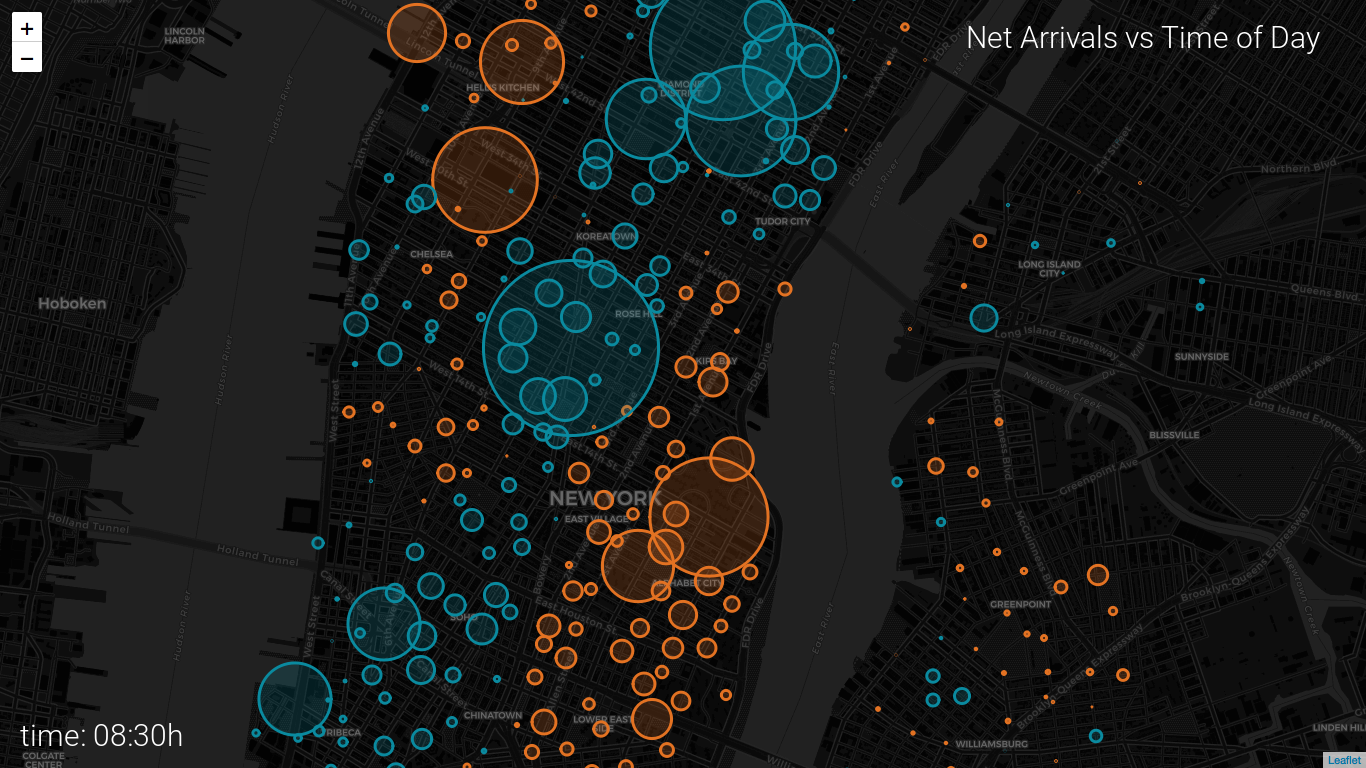

In [20]:
go_arrivals_frame(1, 8.5, "frames")

In [ ]:
for i, hour in enumerate(np.arange(6, 23, .2)):
    go_arrivals_frame(i, hour, "frames")

In [7]:
# make a list of frame times
frame_times = list(enumerate(np.arange(6, 23, .2)))

# p = Pool(5)

start_time = time.time()

list(map(go_arrivals_frame,frame_times))

# p.map(go_frame,frame_times)

print("time elapsed: {}".format(time.time()-start_time))
# p.close()

time elapsed: 2505.653697013855


We can convert the resulting images into a movie using ffmpeg (or your favorite video editing program). We will do this from the command line like this:
```
ffmpeg -r 10 -i frames/frame_%05d.png -c:v libx264 -vf fps=25 -pix_fmt yuv420p output.mp4
```
This should give you a video that will play in most video players, if you want better quality, and more true colors, try this variation:
```
ffmpeg -r 10 -i frames/frame_%05d.png -c:v libx264 -vf fps=25 -crf 17  output.mp4
```

## Individual Trips

In [4]:
def get_path_progress(trips, image_time):
    trip_duration = trips["Stop Time"] - trips["Start Time"]
    path_progress = (image_time - trips["Start Time"]) / trip_duration 
    return path_progress

def get_current_position(trips, progress):
    current_latitude = trips["Start Station Latitude"]*(1- progress) + \
                       trips["End Station Latitude"]* progress
    current_longitude = trips["Start Station Longitude"]*(1- progress) + \
                       trips["End Station Longitude"]* progress
    return current_latitude, current_longitude


def get_active_trips(image_time, bike_data, image_shape, line_len = .1):
    
    bounds = cf.get_min_max(bike_data)
    
    active_trips = bike_data[(bike_data["Start Time"]<=image_time)]
    active_trips = active_trips[(active_trips["Stop Time"]>=image_time)].copy()
    
    progress = get_path_progress(active_trips, image_time)
    
    current_latitude, current_longitude = get_current_position(active_trips, progress)
    start_latitude, start_longitude = get_current_position(active_trips, np.clip(progress-line_len, 0, 1))
    
    start_y, start_x = cf.latlon_to_pixel(start_latitude, 
                                          start_longitude, 
                                          image_shape,
                                          bounds)
    
    end_y, end_x = cf.latlon_to_pixel(current_latitude, 
                                      current_longitude, 
                                      image_shape,
                                      bounds)
    xys = list(zip(start_x, start_y, end_x, end_y))
    weights = np.clip((1 - progress.values)*100, 0, 1)
    
    return xys, weights
    

In [5]:
def row_to_pixel(row, image_shape, bounds):
    """
    convert a row (1 trip) to pixel coordinates
    of start and end point
    """
    start_y, start_x = cf.latlon_to_pixel(row["Start Latitude"], 
                                          row["Start Longitude"], 
                                          image_shape,
                                          bounds)
    end_y, end_x = cf.latlon_to_pixel(row["End Latitude"], 
                                      row["End Longitude"], 
                                      image_shape,
                                      bounds)
    xy = (start_x, start_y, end_x, end_y)
    return xy

In [6]:
def get_image_map(frame_time, bike_data):
    image_data = np.zeros((900*2,400*2))
    bounds = cf.get_min_max(bike_data)
    
    xys, weights = get_active_trips(frame_time, bike_data, image_data.shape, line_len=.01)
    #print(xys, weights)
    image_data = cf.add_lines(image_data, xys, weights=weights*20, width = 4)
    
    xys, weights = get_active_trips(frame_time, bike_data, image_data.shape, line_len=1)
    image_data = cf.add_lines(image_data, xys, weights=weights*10, width = 2)
    return cf.create_image_map(image_data, bounds)

In [7]:
get_image_map(pd.to_datetime('2016-10-05 09:00:00'), bike_data)

In [11]:
def go_frame(params):
    i, frame_time = params
    
    my_frame = get_image_map(frame_time, bike_data)
    png = my_frame._to_png()
    
    image = Image.open(io.BytesIO(png))
    draw = ImageDraw.ImageDraw(image)
    font = ImageFont.truetype("Roboto-Light.ttf", 30)
    draw.text((20,image.height - 50), 
              "time: {}".format(frame_time),
              fill=(255, 255, 255), 
              font=font)
    
    # write to a png file
    image.save(os.path.join("path_frames", "frame_{:0>5}.png".format(i)), "PNG")

In [9]:
go_frame((1,pd.to_datetime('2016-10-05 00:06:00')))

TypeError: _to_png() got an unexpected keyword argument 'delay'

In [12]:
start_time = pd.to_datetime('2016-10-05 09:00:00')
frame_times = [(i, start_time + datetime.timedelta(seconds=30*i)) for i in range(int(120))]

# p = Pool(5)

t0 = time.time()
list(map(go_frame,frame_times))
# p.map(go_frame,frame_times)
# p.close()
print("time elapsed: {}".format(time.time()-t0))

time elapsed: 3541.196617126465


## Make frames for Title Gif
For the header of the totorial article, we want to use an animation that will play automatically in most browsers. We also want it to look smooth. So we will make a GIF with frames that first move forward in time and then backwards.

In [14]:
hours = list(np.arange(6, 10, .2))
hours = hours + hours[::-1]
for i, hour in enumerate(hours):
    go_arrivals_frame(i, hour, "gif_frames")